# Sentiment Analysis with Machine Learning

## Import the necessary libraries

In [1]:
from typing import List, Dict
from collections import Counter
import re
import string
import math
from tqdm.notebook import tqdm
from scipy.special import softmax
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset_builder, load_dataset, get_dataset_split_names, concatenate_datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 

nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')
nltk.download('stopwords')
nltk.download('vader_lexicon')

plt.style.use('ggplot')

[nltk_data] Downloading package punkt_tab to /Users/danc/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/danc/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /Users/danc/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!
[nltk_data] Downloading package words to /Users/danc/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/danc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/danc/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Check the features of the IMDb dataset, then load the dataset

In [2]:
ds_builder = load_dataset_builder("imdb")

# Inspect dataset features
ds_builder.info.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

In [3]:
# Load the IMDb dataset from Hugging Face
imdb = load_dataset("imdb")

In [4]:
# Check the dataset split names
get_dataset_split_names("imdb")

['train', 'test', 'unsupervised']

In [5]:
# Check the dataset
imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [6]:
# Check the training dataset
ds_train = imdb['train']
ds_train

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

In [7]:
# Check the test dataset
ds_test = imdb['test']
ds_test

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

In [8]:
# Concatenate the training and test datasets so we can shuffle and split later
ds = concatenate_datasets([ds_train, ds_test])
ds

Dataset({
    features: ['text', 'label'],
    num_rows: 50000
})

In [9]:
# Check the unsupervised dataset
ds_unsupervised = imdb['unsupervised']
ds_unsupervised

Dataset({
    features: ['text', 'label'],
    num_rows: 50000
})

## Exploratory Data Analysis (EDA)

In [10]:
# Use pandas to check for missing texts and labels
df = pd.DataFrame(ds) # convert the dataset to a pandas dataframe
num_missing_texts = df['text'].isna().sum()
print(f'Number of missing texts: {num_missing_texts}')

num_missing_labels = df['label'].isna().sum()
print(f'Number of missing labels: {num_missing_labels}')

Number of missing texts: 0
Number of missing labels: 0


In [11]:
# Add a new column to the dataframe to store the word count of each text
df['length'] = df['text'].apply(lambda x: len(x.split()))
df['length'].describe()

count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: length, dtype: float64

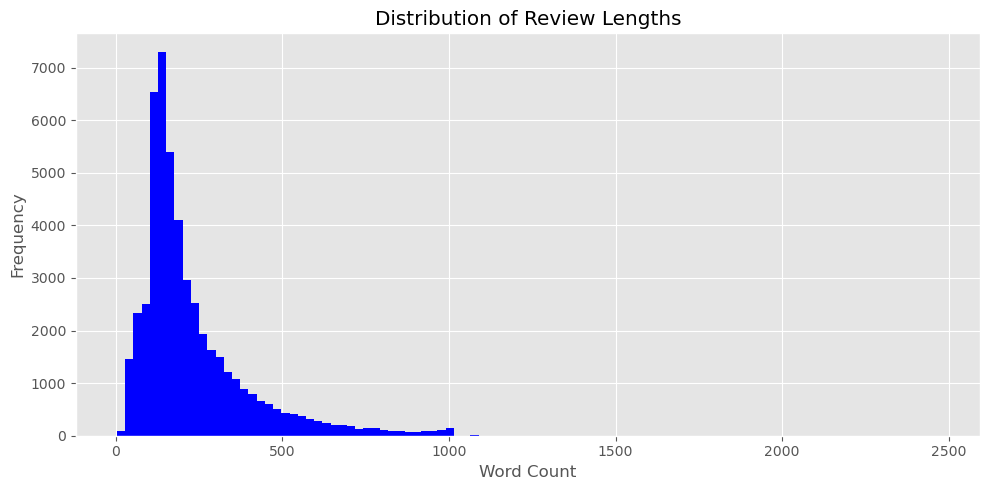

In [12]:
# Check the distribution of the review lengths (word count)
df['length'].plot(kind='hist', bins=100, figsize=(10, 5), title='Distribution of Review Lengths',\
                   xlabel='Word Count', ylabel='Frequency', color='blue')
plt.tight_layout()
plt.show()

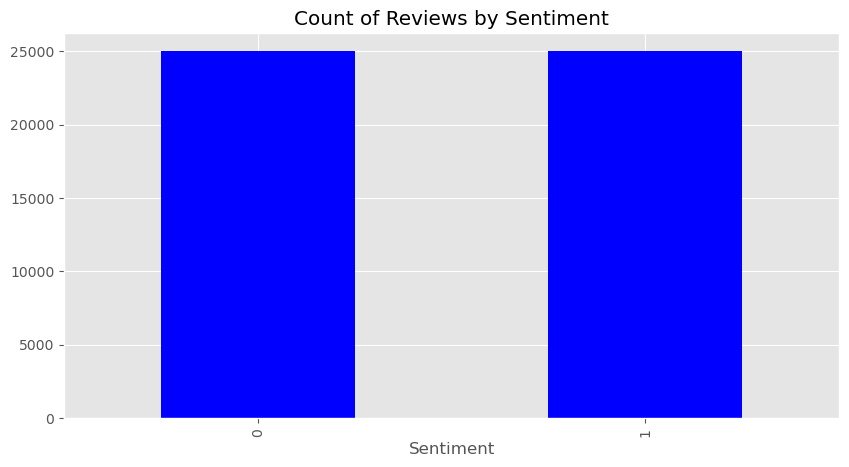

In [13]:
# Check the distribution of the sentiment labels
ax = df['label'].value_counts().sort_index() \
    .plot(kind='bar',color='blue',
          title='Count of Reviews by Sentiment',
          figsize=(10, 5))
ax.set_xlabel('Sentiment')
plt.show()

## Text Preprocessing

In [14]:
# Check the first text in the dataset
example_text = df.iloc[0]['text']
example_text

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

In [16]:
def preprocess_text(text: str) -> List[str]:
    """
    Preprocess the text and remove unnecessary characters.
    
    Args:
        text (str): The input text to preprocess
        
    Returns:
        List[str]: A list of tokens after tokenizing, removing stopwords, and stemming
    """
    # remove hyperlinks
    new_text = re.sub(r'https?://[^\s\n\r]+', '', text)
    # remove punctuation
    new_text = re.sub(r'[^\w\s]', '', new_text)
    # remove hashtags
    new_text = re.sub(r'#', '', new_text)
    # remove numbers
    new_text = re.sub(r'\d+', '', new_text)
    # tokenize the text
    tokens = nltk.word_tokenize(new_text.lower())
    # collect stopwords
    stop_words = set(stopwords.words('english'))
    # set up the stemmer
    stemmer = PorterStemmer()
    # remove stopwords and stem the words
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]

    return tokens

In [17]:
preprocess_text(example_text)

['rent',
 'curiousyellow',
 'video',
 'store',
 'controversi',
 'surround',
 'first',
 'releas',
 'also',
 'heard',
 'first',
 'seiz',
 'us',
 'custom',
 'ever',
 'tri',
 'enter',
 'countri',
 'therefor',
 'fan',
 'film',
 'consid',
 'controversi',
 'realli',
 'see',
 'myselfbr',
 'br',
 'plot',
 'center',
 'around',
 'young',
 'swedish',
 'drama',
 'student',
 'name',
 'lena',
 'want',
 'learn',
 'everyth',
 'life',
 'particular',
 'want',
 'focu',
 'attent',
 'make',
 'sort',
 'documentari',
 'averag',
 'swede',
 'thought',
 'certain',
 'polit',
 'issu',
 'vietnam',
 'war',
 'race',
 'issu',
 'unit',
 'state',
 'ask',
 'politician',
 'ordinari',
 'denizen',
 'stockholm',
 'opinion',
 'polit',
 'sex',
 'drama',
 'teacher',
 'classmat',
 'marri',
 'menbr',
 'br',
 'kill',
 'curiousyellow',
 'year',
 'ago',
 'consid',
 'pornograph',
 'realli',
 'sex',
 'nuditi',
 'scene',
 'far',
 'even',
 'shot',
 'like',
 'cheapli',
 'made',
 'porno',
 'countrymen',
 'mind',
 'find',
 'shock',
 'reali

In [19]:
# Apply the preprocessing function to the entire dataset
tqdm.pandas() # enable tqdm for pandas
df['tokens'] = df['text'].progress_apply(preprocess_text) # apply the preprocessing function to the text column
df

  0%|          | 0/50000 [00:00<?, ?it/s]

,text,label,length,tokens
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,288,"[rent, curiousyellow, video, store, controvers..."
1,"""I Am Curious: Yellow"" is a risible and preten...",0,214,"[curiou, yellow, risibl, pretenti, steam, pile..."
2,If only to avoid making this type of film in t...,0,93,"[avoid, make, type, film, futur, film, interes..."
3,This film was probably inspired by Godard's Ma...,0,118,"[film, probabl, inspir, godard, masculin, fémi..."
4,"Oh, brother...after hearing about this ridicul...",0,311,"[oh, brotheraft, hear, ridicul, film, umpteen,..."
...,...,...,...,...
49995,Just got around to seeing Monster Man yesterda...,1,744,"[got, around, see, monster, man, yesterday, lo..."
49996,I got this as part of a competition prize. I w...,1,116,"[got, part, competit, prize, watch, realli, ex..."
49997,I got Monster Man in a box set of three films ...,1,212,"[got, monster, man, box, set, three, film, mai..."
49998,"Five minutes in, i started to feel how naff th...",1,380,"[five, minut, start, feel, naff, look, youv, g..."


In [21]:
# Add a new column to the dataframe to store the token counts of each text
df['token_count'] = df['tokens'].apply(len)
df['token_count'].describe()

count    50000.00000
mean       121.54022
std         91.57454
min          3.00000
25%         65.00000
50%         90.00000
75%        148.00000
max       1440.00000
Name: token_count, dtype: float64

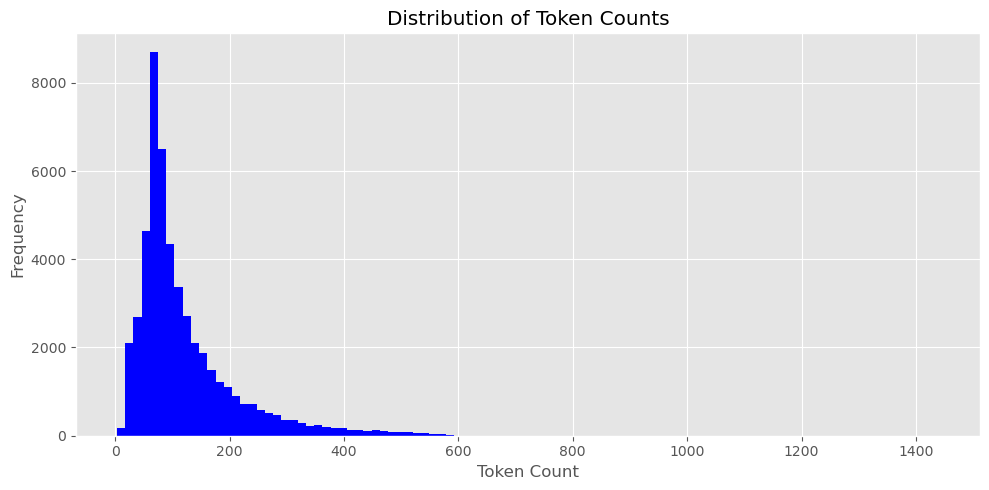

In [22]:
# Check the distribution of the token counts
df['token_count'].plot(kind='hist', bins=100, figsize=(10, 5), title='Distribution of Token Counts',\
                       xlabel='Token Count', ylabel='Frequency', color='blue')
plt.tight_layout()
plt.show()

## Model Building

### Shuffle and split the dataset

In [ ]:
# Shuffle the dataset
shuffled_df = df.sample(frac=1, random_state=12).reset_index(drop=True)
shuffled_df.head()


In [85]:
# Split the dataset into training, validation, and test sets
df_train = shuffled_df.iloc[:30000]
df_val = shuffled_df.iloc[30000:40000]
df_test = shuffled_df.iloc[40000:50000]

#df_train.head()
#df_val.head()
#df_test.head()

## Model Evaluation

### Use the VADER model as a baseline

In [ ]:
# VADER (Valence Aware Dictionary and Sentiment Reasoner), ignoring contexts
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()
#sia.polarity_scores(example_text)

# Run the polarity score on the test set
tqdm.pandas()
vaders = df_test.progress_apply(lambda row: sia.polarity_scores(row['text']), axis=1)
vaders = pd.DataFrame(vaders)

# merge the VADER scores with the test set
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
df_test = df_test.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df_test, how='right')
vaders

# plot VADER scores by sentiment label
ax = sns.barplot(data=vaders, x='label', y='compound')
ax.set_title('Compound Score by Sentiment Label')
plt.show()

# plot VADER sub-scores by sentiment label
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='label', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='label', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='label', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

### Use the Roberta pretrained model for sentiment analysis

In [ ]:
# get the Roberta model
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# try to run the model on Mac GPUs
# check if MPS (Metal Performance Shaders) is available
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Load the tokenizer and model
model = model.to(device)

# Run the Roberta model with batch input using GPUs
def polarity_scores_roberta_gpu_batch(texts: List[str], batch_size: int = 256) -> Dict[int, Dict[str, float]]:
    """
    Analyze sentiment for a batch of texts using the Roberta model.
        
    Args:
        texts (List[str]): List of input texts
        batch_size (int): Size of the batch to process
            
    Returns:
        Dict[int, Dict[str, float]]: Dictionary of dictionaries containing sentiment probabilities
    """

    scores_dict = {}
    num_batches = math.ceil(len(texts) / batch_size)
         
    for i in tqdm(range(num_batches)):
        # Get the batch of texts
        batch_texts = texts[i*batch_size : (i+1)*batch_size]
        
        # Tokenize with truncation
        encoded_text = tokenizer(
                 batch_texts, 
                 return_tensors='pt', 
                 truncation=True, 
                 padding=True, 
                 max_length=512
             ).to(device)
             
        # Run inference
        with torch.no_grad():
            outputs = model(**encoded_text)
            probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
             
        # Get predictions
        for j, probs in enumerate(probabilities.cpu().numpy()):
            idx = i * batch_size + j
            scores_dict[idx] = {
                     "roberta_neg": float(probs[0]),
                     "roberta_neu": float(probs[1]),
                     "roberta_pos": float(probs[2])
                 }
         
    return scores_dict

roberta_batch_result = polarity_scores_roberta_gpu_batch(list(df_test['text']))
roberta_batch_result

# compare the VADER and Roberta scores
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='label',
            palette='tab10')
plt.show()

# sanity check the VADER and Roberta scores
results_df.query('label == 0') \
    .sort_values('roberta_pos', ascending=False)['text'].values[0]

results_df.query('label == 0') \
    .sort_values('vader_pos', ascending=False)['text'].values[0]

results_df.query('label == 1') \
    .sort_values('roberta_neg', ascending=False)['text'].values[0]

results_df.query('label == 1') \
    .sort_values('vader_neg', ascending=False)['text'].values[0]

### Use the Hugging Face pipeline for sentiment analysis

In [ ]:
# Use the Transformers Pipeline for sentiment analysis
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

In [ ]:
sent_pipeline(example_text)
sent_pipeline('I love sentiment analysis!')
sent_pipeline('I hate having no gpus!')
sent_pipeline('What a beautiful day! All my clothes got wet!')

## Retrieval Augmented Generation (RAG)